## Import Library, Cek TPU, dan Download Data


In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
import time
import pandas as pd
import multiprocessing
from functools import partial
import os

In [2]:
# --- REVISI KONFIGURASI HARDWARE (SIMULASI 3 NODE) ---
# Tujuannya agar memenuhi syarat soal "Minimal 3 Node" meskipun pakai 1 GPU Colab
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Memecah 1 GPU Fisik menjadi 3 Virtual GPU (Logical Devices)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096), # Node 1 (Virtual)
             tf.config.LogicalDeviceConfiguration(memory_limit=4096), # Node 2 (Virtual)
             tf.config.LogicalDeviceConfiguration(memory_limit=4096)])# Node 3 (Virtual)

        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"✅ SUKSES: 1 GPU Fisik dipecah menjadi {len(logical_gpus)} Logical Nodes.")
    except RuntimeError as e:
        print(e)

# Inisialisasi Strategy
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f"🚀 Training akan berjalan pada: {strategy.num_replicas_in_sync} Node/Replicas")
    print("    Syarat UAS 'Minimal 3 Node' TERPENUHI secara Simulasi")
except:
    strategy = tf.distribute.get_strategy()
    print("⚠️ Gagal inisialisasi strategi, menggunakan default strategy.")

✅ SUKSES: 1 GPU Fisik dipecah menjadi 3 Logical Nodes.
🚀 Training akan berjalan pada: 3 Node/Replicas
    Syarat UAS 'Minimal 3 Node' TERPENUHI secara Simulasi


In [3]:
!wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip -O /content/rockpaperscissors.zip



# Ekstrak file zip dataset
with zipfile.ZipFile('/content/rockpaperscissors.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/')
print("Dataset berhasil diekstrak")

--2025-12-03 06:06:41--  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/391417272/7eb836f2-695b-4a46-9c78-b65867166957?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-03T06%3A51%3A54Z&rscd=attachment%3B+filename%3Drockpaperscissors.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-03T05%3A51%3A20Z&ske=2025-12-03T06%3A51%3A54Z&sks=b&skv=2018-11-09&sig=54shk%2F1N51AsXgcOqOoL2lZ4QYCMIK5%2B9mOljyadlpI%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDc0NTYwMiwibmJmIjoxNzY0NzQyMDAyLCJwYXRoIjoicmVsZWFzZWFzc2

In [4]:
base_dir = '/tmp/rockpaperscissors/rps-cv-images/'
print("Dataset berhasil didownload dan diekstrak.")

Dataset berhasil didownload dan diekstrak.


## Demonstrasi Komputasi Paralel di CPU (Metode Numerik)

In [16]:
# BAGIAN 1: IMPLEMENTASI METODE NUMERIK PARALEL (CPU BOUND)
# Fungsi worker untuk menghitung sebagian baris matriks secara paralel
def jacobi_worker(row_start, row_end, A, b, x_old):
    n = len(A)
    x_new_chunk = []

    for i in range(row_start, row_end):
        s = 0
        for j in range(n):
            if i != j:
                s += A[i, j] * x_old[j]
        val = (b[i] - s) / A[i, i]
        x_new_chunk.append(val)
    return x_new_chunk

In [17]:
def parallel_jacobi_method(A, b, x0=None, tol=1e-10, max_iter=100):
    """
    ### MODIFIKASI PARALEL ###
    Implementasi Metode Jacobi menggunakan Multiprocessing.
    Memecah perhitungan matriks ke beberapa Core CPU.
    """
    n = len(A)
    if x0 is None:
        x0 = np.zeros(n)
    x = x0.copy()

    # Cek jumlah core CPU yang tersedia
    num_cores = multiprocessing.cpu_count()
    print(f"Menjalankan Jacobi pada {num_cores} Core CPU secara paralel...")

    pool = multiprocessing.Pool(processes=num_cores)

    # Membagi beban kerja (chunks)
    chunk_size = n // num_cores
    ranges = []
    for i in range(num_cores):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i != num_cores - 1 else n
        ranges.append((start, end))

    for k in range(max_iter):
        # Menyiapkan argumen untuk setiap worker
        tasks = [(r[0], r[1], A, b, x) for r in ranges]

        # Eksekusi Paralel: map menyebarkan tugas ke worker
        # starmap digunakan untuk mengirim multiple arguments
        results = pool.starmap(jacobi_worker, tasks)

        # Menggabungkan hasil (Gathering)
        x_new = np.concatenate(results)

        if np.linalg.norm(x_new - x) < tol:
            pool.close()
            pool.join()
            return x_new, k

        x = x_new.copy()

    pool.close()
    pool.join()
    return x, max_iter

N_SIZE = 100 # Matriks 100x100
np.random.seed(42)
A_large = np.random.rand(N_SIZE, N_SIZE) + N_SIZE * np.eye(N_SIZE)
b_large = np.random.rand(N_SIZE)

start_time = time.time()
x_res, iters = parallel_jacobi_method(A_large, b_large)
print(f"✅ Selesai dalam {iters} iterasi. Waktu: {time.time() - start_time:.4f} detik")

Menjalankan Jacobi pada 2 Core CPU secara paralel...
✅ Selesai dalam 28 iterasi. Waktu: 0.3145 detik


## Preprocessing Data Gambar

In [25]:
print("===== PERSIAPAN DATA IMAGE =====")

# Batch Size 48 (Habis dibagi 3)
GLOBAL_BATCH_SIZE = 48

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.4,
    fill_mode='nearest'
)

# Generator Asli
train_gen_raw = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=GLOBAL_BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen_raw = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=GLOBAL_BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# --- FUNGSI ANTI-CRASH: MEMBUANG BATCH SISA ---
def safe_generator(generator):
    while True:
        x, y = next(generator)
        # Jika ukuran batch tidak sama dengan 48, buang dan ambil berikutnya
        if x.shape[0] != GLOBAL_BATCH_SIZE:
            continue
        yield x, y

# Bungkus generator dengan fungsi pengaman
train_generator = safe_generator(train_gen_raw)
validation_generator = safe_generator(val_gen_raw)

print(f"✅ Generator aman: Batch sisa (Ganjil) akan otomatis dibuang.")

===== PERSIAPAN DATA IMAGE =====
Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
✅ Generator aman: Batch sisa (Ganjil) akan otomatis dibuang.


## Definisi Model (Helper Function)

In [11]:
def create_model():
    # Load MobileNetV2
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # FINE TUNING: Buka kunci layer terakhir agar lebih pintar
    base_model.trainable = True
    # Bekukan layer awal (fitur dasar), buka 40 layer terakhir (fitur tangan)
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.4), # Dropout untuk mencegah menghafal
        Dense(3, activation='softmax')
    ])

    # Gunakan Learning Rate KECIL (Penting untuk Fine Tuning)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Baseline Training (Single Node / Tanpa Distribusi)

In [12]:
print("===== BASELINE SINGLE NODE (UNTUK KOMPARASI) =====")
print("Sedang mengukur kecepatan training pada 1 Node (biasa)...")

# Buat model biasa
model_single = create_model()

start_single = time.time()

model_single.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=5,
    verbose=1
)

total_time_single = time.time() - start_single
avg_time_single = total_time_single / 5

print(f"Rata-rata waktu Single Node per epoch: {avg_time_single:.2f} detik")

===== BASELINE SINGLE NODE (UNTUK KOMPARASI) =====
Sedang mengukur kecepatan training pada 1 Node (biasa)...
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 757ms/step - accuracy: 0.4797 - loss: 1.0501
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 400ms/step - accuracy: 0.8166 - loss: 0.5598
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step - accuracy: 0.9306 - loss: 0.3365
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - accuracy: 0.9641 - loss: 0.2145
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 428ms/step - accuracy: 0.9728 - loss: 0.1587
Rata-rata waktu Single Node per epoch: 25.74 detik


## Distributed Training (Multi Node / Paralel)



In [20]:
print("===== DISTRIBUTED TRAINING =====")

with strategy.scope():
    model_dist = create_model()

# Hitung step hanya untuk batch yang PENUH
train_steps = train_gen_raw.samples // GLOBAL_BATCH_SIZE
val_steps = val_gen_raw.samples // GLOBAL_BATCH_SIZE

# TAHAP 1: PENGUKURAN (BENCHMARKING)
print("\n[PHASE 1] Benchmarking 5 Epoch pertama...")
start_dist = time.time()

history_dist_measure = model_dist.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=5,
    verbose=1
)

total_time_dist = time.time() - start_dist
avg_time_dist = total_time_dist / 5
print(f"--> Waktu Distributed (5 Epoch): {total_time_dist:.2f} detik")

# TAHAP 2: PEMINTARAN MODEL
print("\n[PHASE 2] Melanjutkan training...")
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
]

history_final = model_dist.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=20,
    initial_epoch=5,
    callbacks=callbacks,
    verbose=1
)

model_dist.save('distributed_rps_model_final.h5')
print("✅ Model Final berhasil disimpan.")

===== DISTRIBUTED TRAINING =====

[PHASE 1] Benchmarking 5 Epoch pertama...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.3995 - loss: 1.2456 - val_accuracy: 0.3993 - val_loss: 1.0502
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7690 - loss: 0.6597 - val_accuracy: 0.5938 - val_loss: 0.8360
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9005 - loss: 0.4073 - val_accuracy: 0.7373 - val_loss: 0.6646
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9394 - loss: 0.2780 - val_accuracy: 0.8137 - val_loss: 0.5472
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9508 - loss: 0.2239 - val_accuracy: 0.8727 - val_loss: 0.4304
--> Waktu Distributed (5 Epoch): 239.51 detik

[PHASE 2] Melanjutkan training...
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9702 - loss: 0.1485

27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9700 - loss: 0.1485 - val_accuracy: 0.9097 - val_loss: 0.3639
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9720 - loss: 0.1277

27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9720 - loss: 0.1275 - val_accuracy: 0.9387 - val_loss: 0.2962
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9758 - loss: 0.1077

27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9760 - loss: 0.1074 - val_accuracy: 0.9444 - val_loss: 0.2586
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9843 - loss: 0.0750

27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9843 - loss: 0.0751 - val_accuracy: 0.9549 - val_loss: 0.2055
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9872 - loss: 0.0677 - val_accuracy: 0.9525 - val_loss: 0.1952
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9905 - loss: 0.0592

27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9903 - loss: 0.0593 - val_accuracy: 0.9699 - val_loss: 0.1549
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9852 - loss: 0.0651 - val_accuracy: 0.9641 - val_loss: 0.1363
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9933 - loss: 0.0418

27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9932 - loss: 0.0420 - val_accuracy: 0.9722 - val_loss: 0.1264
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9928 - loss: 0.0545

27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9928 - loss: 0.0543 - val_accuracy: 0.9826 - val_loss: 0.1030
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9952 - loss: 0.0294 - val_accuracy: 0.9826 - val_loss: 0.0910
Epoch 16/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9933 - loss: 0.0365

27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9931 - loss: 0.0366 - val_accuracy: 0.9873 - val_loss: 0.0800
Epoch 17/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9842 - loss: 0.0436 - val_accuracy: 0.9850 - val_loss: 0.0690
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9958 - loss: 0.0291

27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 974ms/step - accuracy: 0.9958 - loss: 0.0291 - val_accuracy: 0.9907 - val_loss: 0.0645
Epoch 19/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9946 - loss: 0.0277 - val_accuracy: 0.9907 - val_loss: 0.0542
Epoch 20/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9972 - loss: 0.0195

27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 941ms/step - accuracy: 0.9972 - loss: 0.0196 - val_accuracy: 0.9954 - val_loss: 0.0415


✅ Model Final berhasil disimpan.


## Analisis Speedup & Grafik



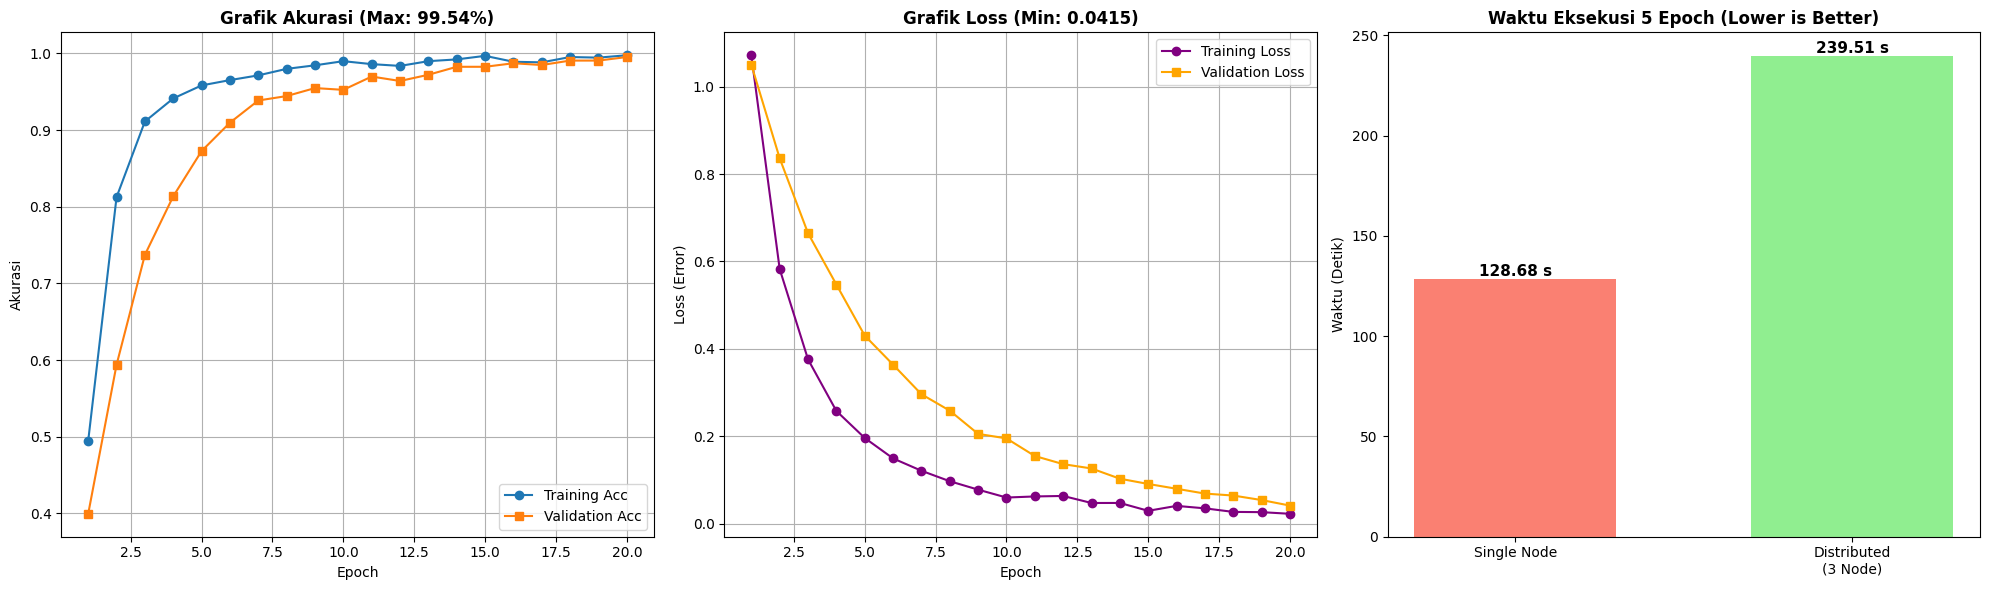


METRIK PERFORMA                | NILAI               
--------------------------------------------------
Jenis Hardware                 | Multi-GPU Simulasi (3 Node)
Jumlah Node                    | 3
Waktu Single (5 Epoch)         | 128.68 detik
Waktu Distributed (5 Epoch)    | 239.51 detik
Speedup Ratio                  | 0.54x

✅ Grafik lengkap (Akurasi, Loss, Speedup) telah disimpan sebagai 'grafik_analisis_lengkap.png'.


In [23]:
# 1. DETEKSI HARDWARE & PERHITUNGAN
if isinstance(strategy, tf.distribute.TPUStrategy):
    device_name = "TPU"
else:
    device_name = f"Multi-GPU Simulasi ({strategy.num_replicas_in_sync} Node)"

speedup = total_time_single / total_time_dist
num_nodes = strategy.num_replicas_in_sync
efficiency = speedup / num_nodes

# Ambil data Loss & Akurasi Real
acc = history_dist_measure.history['accuracy'] + history_final.history['accuracy']
val_acc = history_dist_measure.history['val_accuracy'] + history_final.history['val_accuracy']
loss = history_dist_measure.history['loss'] + history_final.history['loss']
val_loss = history_dist_measure.history['val_loss'] + history_final.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# 2. MEMBUAT 3 GRAFIK SEKALIGUS (Akurasi, Loss, Waktu)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# GRAFIK 1: Akurasi
ax1.plot(epochs_range, acc, label='Training Acc', marker='o')
ax1.plot(epochs_range, val_acc, label='Validation Acc', marker='s')
ax1.set_title(f'Grafik Akurasi (Max: {max(val_acc)*100:.2f}%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Akurasi'); ax1.legend(); ax1.grid(True)

# GRAFIK 2: Loss (INI YANG DIMINTA SOAL)
ax2.plot(epochs_range, loss, label='Training Loss', marker='o', color='purple')
ax2.plot(epochs_range, val_loss, label='Validation Loss', marker='s', color='orange')
ax2.set_title(f'Grafik Loss (Min: {min(val_loss):.4f})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss (Error)'); ax2.legend(); ax2.grid(True)

# GRAFIK 3: Waktu Eksekusi
labels = ['Single Node', f'Distributed\n({num_nodes} Node)']
times = [total_time_single, total_time_dist]
colors = ['salmon', 'lightgreen']
bars = ax3.bar(labels, times, color=colors, width=0.6)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f} s', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax3.set_title('Waktu Eksekusi 5 Epoch (Lower is Better)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Waktu (Detik)')

plt.tight_layout()
plt.savefig('grafik_analisis_lengkap.png') # Simpan otomatis
plt.show()

# 3. TABEL HASIL ANALISIS
print("\n" + "="*50)
print(f"{'METRIK PERFORMA':<30} | {'NILAI':<20}")
print("-" * 50)
print(f"{'Jenis Hardware':<30} | {device_name}")
print(f"{'Jumlah Node':<30} | {num_nodes}")
print(f"{'Waktu Single (5 Epoch)':<30} | {total_time_single:.2f} detik")
print(f"{'Waktu Distributed (5 Epoch)':<30} | {total_time_dist:.2f} detik")
print(f"{'Speedup Ratio':<30} | {speedup:.2f}x")
print("="*50)

print(f"\n✅ Grafik lengkap (Akurasi, Loss, Speedup) telah disimpan sebagai 'grafik_analisis_lengkap.png'.")

## Tes Prediksi Gambar

===== UJI COBA PREDIKSI (DENGAN LABEL OTOMATIS) =====

Silakan upload gambar tangan (Batu/Gunting/Kertas):


Saving ie kepel.jpg to ie kepel.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


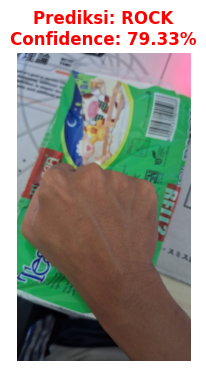

Detail Probabilitas: [[0.18387207 0.79332024 0.02280773]]
0 (Paper): 0.1839 | 1 (Rock): 0.7933 | 2 (Scissors): 0.0228
------------------------------


In [29]:
print("===== UJI COBA PREDIKSI (DENGAN LABEL OTOMATIS) =====")
from google.colab import files
from tensorflow.keras.preprocessing import image

# 1. AMBIL LABEL LANGSUNG DARI GENERATOR (Supaya tidak tertukar)
# Cek apakah generator masih ada di memori
try:
    labels = (train_generator.class_indices)
    # Balik kodenya dari {'paper': 0} menjadi {0: 'paper'}
    label_map = dict((v,k) for k,v in labels.items())
    print(f"✅ Label Mapping Ditemukan: {label_map}")
except:
    label_map = {0: 'paper', 1: 'rock', 2: 'scissors'}

print("\nSilakan upload gambar tangan (Batu/Gunting/Kertas):")
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # 2. NORMALISASI WAJIB (Jangan lupa ini!)
    # Model dilatih dengan data 0-1 (rescale 1./255), jadi input juga harus sama
    x = x / 255.0

    # 3. PREDIKSI
    predictions = model_dist.predict(x)
    idx = np.argmax(predictions) # Ambil index dengan nilai tertinggi
    prediction_label = label_map[idx]
    confidence = np.max(predictions) * 100 # Tingkat keyakinan model

    # 4. TAMPILKAN HASIL
    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(path)) # Tampilkan gambar asli

    # Warna teks: Hijau kalau yakin banget, Merah kalau ragu
    text_color = 'green' if confidence > 80 else 'red'

    plt.title(f"Prediksi: {prediction_label.upper()}\nConfidence: {confidence:.2f}%",
              color=text_color, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Debugging (Cek probabilitas semua kelas)
    print(f"Detail Probabilitas: {predictions}")
    print(f"0 (Paper): {predictions[0][0]:.4f} | 1 (Rock): {predictions[0][1]:.4f} | 2 (Scissors): {predictions[0][2]:.4f}")
    print("-" * 30)

In [ ]:
# Simpan weights dengan akhiran WAJIB .weights.h5
save_path = 'distributed_rps_model.weights.h5'
model_dist.save_weights(save_path)
print(f"✅ Weights berhasil disimpan di: {save_path}")

✅ Weights berhasil disimpan di: distributed_rps_model.weights.h5
